# Anomaly Detection Using an Autoencoder

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhysData/course/blob/main/docs/notebooks/data_visualisation.ipynb)

If you're running this in Colab, make sure to save a copy of the notebook in Google Drive to save your changes.

**The datasets used in this notebook**

To detect and visualise hidden anomalies, we will be using the open-source [Numenta Anolmaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab) dataset. The raw versions of the `art_daily_small_noise.csv` and `art_daily_jump.csv` datasets are available [here](https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv) and [here](https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv), respectively. For a deeper understanding of the code cells, the curious reader should familiarise themselves with Python and the `NumPy`, `Matplotlib`and `Pandas` libraries, and possibly the `TensorFlow` platform.

## Setup

In [1]:
# If you're running this notebook, uncomment the code in this cell to install the required packages.
# ! pip install numpy
# ! pip install pandas
# ! pip install tensorflow
# ! pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data

In addition to the NAB dataset, we will use the `art_daily_small_noise.csv` file for training and the `art_daily_jump.csv` file for testing our model. Note that the terms 'test set' and 'validation set' will be used interchangably, and that all three datasets used in this demonstration consist of **synthetic data**. To see how synthetic datasets are generated and why they are useful in data science, take a look at the complementary '[Linear Regression and Coulomb’s Law](https://physicsanddatascience.readthedocs.io/en/latest/notebooks/elmag.html#)' section. The simplicity of these datasets allows us to demonstrate anomaly detection effectively.

The following commands will ensure our datasets are imported and converted from CSV format to a `Pandas` DataFrame to faciliate further analysis:

In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

The artificial timeseries data we will be working with are ordered, timestamped, single-valued metrics, with labeled periods of anomalous behaviour.

Run the commands below for a brief overview of what our training and test sets look like:

In [4]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Visualise the data

### Timeseries data without anomalies

Our main task during the training stage will be to train the model and establish a suitable benchmark for an anomaly. How accurate is our model and what is the threshold for classifying an abnormal datapoint?

Here is the data we will use for training:

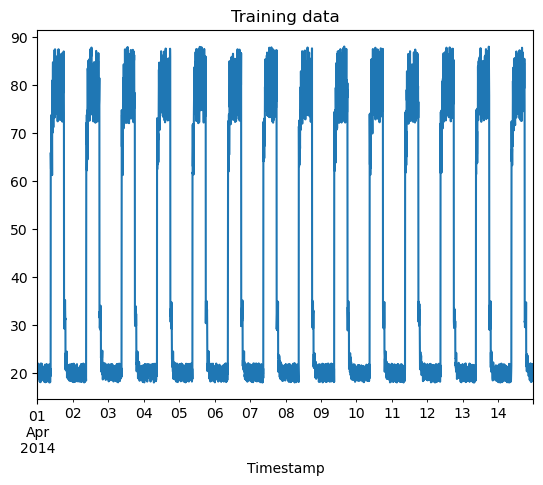

In [5]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.xlabel("Timestamp")
plt.title("Training data")
plt.show()

### Timeseries data with anomalies

To test the autoencoder after the training stage, we want to see whether the spike in our artificial test data will be successfully detected as an anomaly. In practice, this could be a much smaller discrepancy embedded in a noisy astronomical dataset, which we would expect our model to be able to detect and bring to our attention.

Here is our training data visualised:

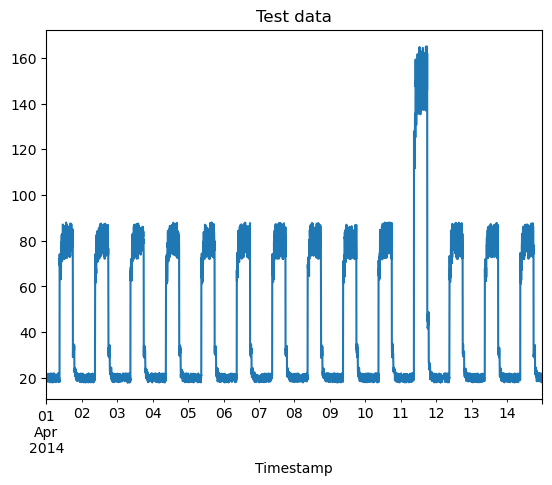

In [6]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.xlabel("Timestamp")
plt.title("Test data")
plt.show()

## Prepare training data

First, isolate the values of interest from the training dataset and normalise the `value` column. Normalisation is done by subtracting the `training_mean` from each `value` datapoint and dividing by the `training_std`. We have a `value` entry every 5 minutes for 14 days, giving us a total of 4032 samples.

In [7]:
# Normalise and save the mean and standard deviation we get for normalising test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

# Output the normalised training data.
print(df_training_value.head())

# Output the number of samples.
print("\nNumber of training samples:", len(df_training_value))

                        value
timestamp                    
2014-04-01 00:00:00 -0.858829
2014-04-01 00:05:00 -0.728993
2014-04-01 00:10:00 -0.848148
2014-04-01 00:15:00 -0.729586
2014-04-01 00:20:00 -0.731173

Number of training samples: 4032


## Create sequences

Create a series of sequences by combining `TIME_STEPS` contiguous data values from the training data, changing the starting index with each iteration:

In [8]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)

# Display the first 4 sequences.
print(x_train[0:4])
print("\nTraining input shape: ", x_train.shape)

[[[-0.85882857]
  [-0.72899302]
  [-0.84814772]
  ...
  [-0.86453747]
  [-0.81250829]
  [-0.79671155]]

 [[-0.72899302]
  [-0.84814772]
  [-0.72958579]
  ...
  [-0.81250829]
  [-0.79671155]
  [-0.78767946]]

 [[-0.84814772]
  [-0.72958579]
  [-0.731173  ]
  ...
  [-0.79671155]
  [-0.78767946]
  [-0.73706287]]

 [[-0.72958579]
  [-0.731173  ]
  [-0.75730984]
  ...
  [-0.78767946]
  [-0.73706287]
  [-0.77462891]]]

Training input shape:  (3745, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model, which will take an input of shape `(batch_size, sequence_length, num_features)` and return an output of the same shape. In this case, `sequence_length` = 288 and `num_features` = 1.

In [9]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the model

Having created the model, we will now supply it with the training data. Note that `x_train` is used as both the input and the target since this is a reconstruction model.

In [10]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 59ms/step - loss: 0.4390 - val_loss: 0.0529
Epoch 2/50
27/27 [==============================] - 1s 43ms/step - loss: 0.0790 - val_loss: 0.0457
Epoch 3/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0608 - val_loss: 0.0390
Epoch 4/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0530 - val_loss: 0.0343
Epoch 5/50
27/27 [==============================] - 1s 48ms/step - loss: 0.0463 - val_loss: 0.0304
Epoch 6/50
27/27 [==============================] - 1s 51ms/step - loss: 0.0402 - val_loss: 0.0252
Epoch 7/50
27/27 [==============================] - 1s 49ms/step - loss: 0.0348 - val_loss: 0.0216
Epoch 8/50
27/27 [==============================] - 1s 49ms/step - loss: 0.0312 - val_loss: 0.0198
Epoch 9/50
27/27 [==============================] - 1s 47ms/step - loss: 0.0287 - val_loss: 0.0188
Epoch 10/50
27/27 [==============================] - 1s 48ms/step - loss: 0.0266 - val_loss: 0.0184
Epoch 11/

Let's plot the training loss and validation loss to see how the model performed. For an optimal fit, we would expect to see the two curves decrease and eventually stabilise at a specific value.

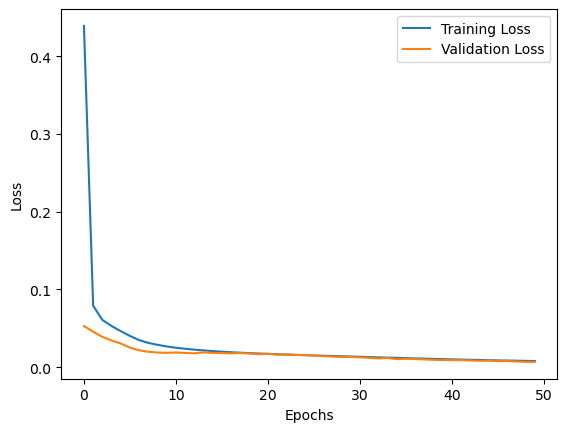

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

1. Find MAE loss on the training samples.
2. Find the maximum MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the `threshold` for anomaly detection.
3. If the reconstruction loss for a sample is greater than this `threshold` value, we can infer that the model is seeing a pattern that it isn't familiar with and will tag this sample as an `anomaly`.

118/118 [==============================] - 2s 11ms/step


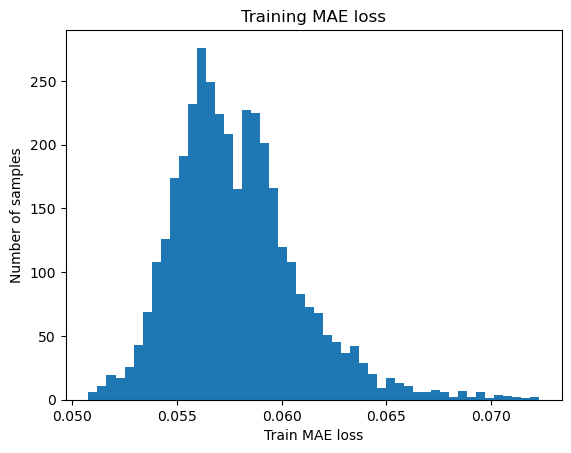

Reconstruction error threshold:  0.07229737499847969


In [12]:
# Get training MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.title("Training MAE loss")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare reconstruction

To see how the model has reconstructed the first sample, run the code below. This sample consists of the contiguous 288 timesteps starting at Day 1 of our training dataset.

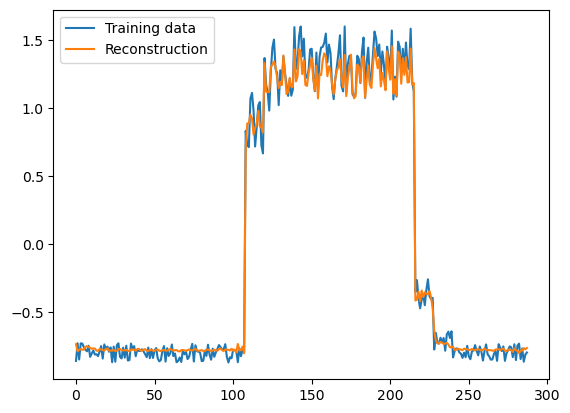

In [13]:
# Check how the first sequence has been learned.
plt.plot(x_train[0], label="Training data")
plt.plot(x_train_pred[0], label="Reconstruction")
plt.legend()
plt.show()

### Prepare test data

Next, we will test the model on our validation dataset. The code below will output the indices of the anomalous datapoints, as well as visualise the normalised validation dataset and plot a histogram showing the distribution of MAE loss.

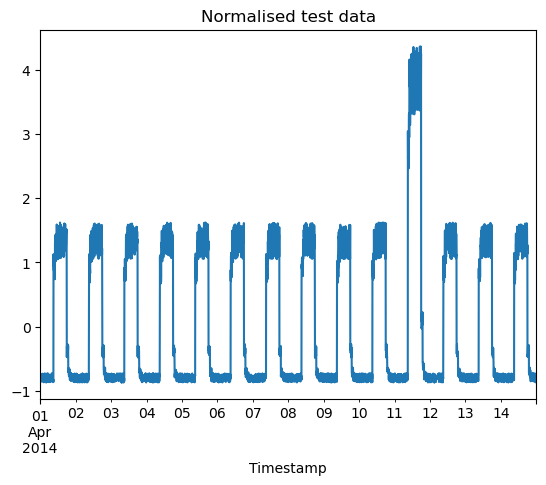

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 1s 11ms/step


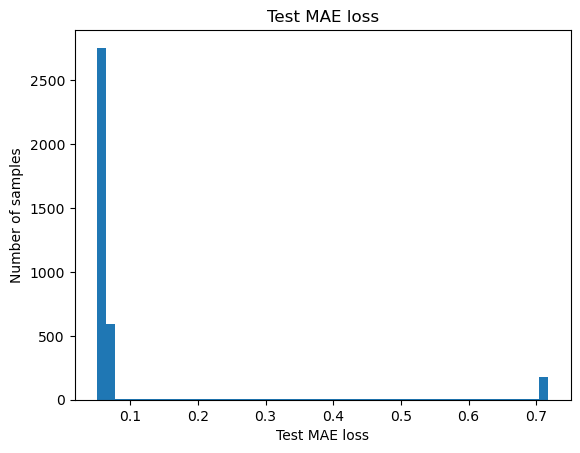

Number of anomaly samples:  414
Indices of anomaly samples:  (array([ 217,  792,  793,  794,  795, 1649, 1657, 1658, 1945, 2518, 2519,
       2521, 2522, 2523, 2698, 2699, 2701, 2702, 2703, 2704, 2705, 2706,
       2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761,
       2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
       2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783,
       2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
       2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805,
       2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2

In [14]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.xlabel("Timestamp")
plt.title("Normalised test data")
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Calculate the test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("Number of samples")
plt.title("Test MAE loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

Having identified the anomalous data, we can now find the corresponding `timestamps` from the original test data using the following method:

Suppose a simple case where `time_steps` = 3. For 10 training values, `x_train` would be:

```
0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
```

All points except the initial and final `time_steps - 1` values will appear in a total of `time_steps` samples. So, if we know that the samples `[(3, 4, 5), (4, 5, 6), (5, 6, 7)]` are anomalies, we can conclude that the datapoint `5` is an anomaly.

Identify the `timestamps` values at which the anomalies occur and compile them into a list:

In [15]:
# Datapoint [i] is an anomaly if samples [(i - time_steps + 1) to (i)] are anomalies.
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Finally, let's overlay the anomalies we found on the original test dataset plot.

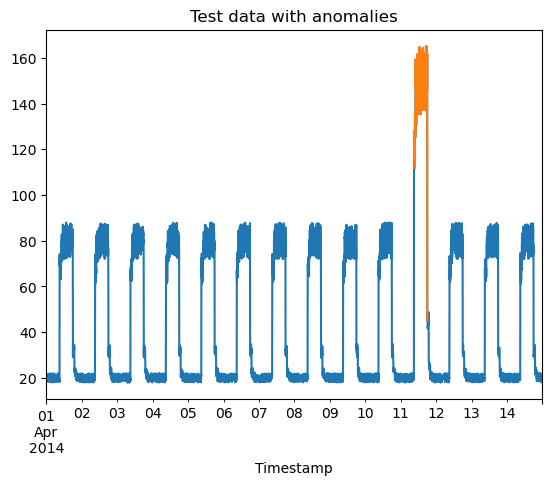

In [16]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax)
plt.xlabel("Timestamp")
plt.title("Test data with anomalies")

plt.show()

## Conclusions

At this point, hopefully it has become clear why visualising and graphing data is an essential component of data science. Compare looking at the indices of the anomalies to looking at the same points superposed on the original plot. While the former is a block of seemingly arbitrary numerical jargon, the latter provides a much more clear overview of this information such that it can be understood from a glance. Not only does this concentrate our attention on the most interesting part of the data, but these insights can be communicated easily to other physicists and laymen. One can also appreciate how delegating this task to a machine saves astronomers such as Jocelyn Bell Burnell from ploughing through months of observational data.

## References

Autoencoder model and NAB dataset:

* https://huggingface.co/keras-io/timeseries-anomaly-detection

* https://www.kaggle.com/datasets/boltzmannbrain/nab

Jocelyn Bell Burnell and pulsars:

* https://www.cam.ac.uk/stories/journeysofdiscovery-pulsars

* https://starchild.gsfc.nasa.gov/docs/StarChild/whos_who_level2/bell.html